"""
*****************************************************************************
* MLops                                                                     *
* OBJETIVO: Entrenar el modelo vinos                                        * 
* INPUT: TBL_ENTRENAMIENTO_MODELO_VINOS.parquet                             *
* OUTPUT: DATA_VINOS_PREPROCESAMIENTO                                       *
* FECHA CREACION: 05/12/2024                                                *
* ***************************************************************************
* MODIFICACIONES
* NOMBRE WUILSON ESTACIO                    
* FECHA 05/12/2024
* VERSION 02
* DESCRIPCION Realiza entrenamiento del modelo y empaque 
******************************************************************************
"""

In [1]:
# pip install azureml-sdk

Note: you may need to restart the kernel to use updated packages.


### Intalacion librerias

In [33]:
# Instalar librerias
import subprocess

# Lista de librerías a instalar
librerias = ['pyspark','findspark','openpyxl','plotly','yellowbrick','jedi','seaborn','azureml-sdk']

# Iterar sobre la lista de librerías y ejecutar el comando de instalación para cada una
for libreria in librerias:
    subprocess.run(['pip', 'install', libreria])

In [4]:
%config IPCompleter.greedy=True

### Librerias

In [ ]:
from azureml.core import Workspace
from mlflow.tracking import MlflowClient

# Conecta al workspace (ajusta los parámetros si usas un archivo config.json)
workspace = Workspace.from_config()

In [5]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from azureml.core.model import Model
import sys
import mlflow
import mlflow.sklearn
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, expr, asc, count, countDistinct, max, collect_list, sum, isnan, isnull, last
from pyspark.sql.functions import col as col_null
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, DateType
# Importar bibliotecas para normalización 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Importar bibliotecas para Modelos
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from mlflow.tracking import MlflowClient


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import pow
from pyspark.sql.functions import mean
from math import sqrt
from azureml.core import Workspace
import tempfile
from sklearn.metrics import confusion_matrix
import os

In [6]:
# Importar bibliotecas visialización
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib

In [7]:
# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("MiAplicacion") \
    .getOrCreate()

24/12/06 20:49:14 WARN Utils: Your hostname, cluster-ml-wilson resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/12/06 20:49:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 20:49:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/06 20:49:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
# Obtener la ruta absoluta del directorio actual
directorio_actual = os.path.abspath(os.getcwd())

ruta_funciones = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/cluster-ml-wilson/code/Users/wadolfoe/Funciones'
sys.path.append(ruta_funciones)
print(ruta_funciones)

# Importar las funciones desde FN_01_ENTRENAMIENTO_ADQUISICION.py
from FN_01_ENTRENAMIENTO_ADQUISICION import FN_EVALUACION_METRICAS, FN_ENTRENAR_MODELOS_ADQUISICION, FN_EXTRACT_PROBA

/mnt/batch/tasks/shared/LS_root/mounts/clusters/cluster-ml-wilson/code/Users/wadolfoe/Funciones


In [9]:
# Configurar Matplotlib para usar una fuente genérica
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # DejaVu Sans es una fuente comúnmente disponible en muchos entornos

### Lectura data

In [10]:
# Ruta del archivo Parquet
output_path = "DATA_VINOS_PREPROCESAMIENTO.parquet"

# output_path = "Users/wadolfoe/Procesos/output_data/DATA_VINOS_PREPROCESAMIENTO.parquet"
# Leer el archivo Parquet
df_ml = spark.read.parquet(output_path)

In [11]:
df_ml.select('Target','features').tail(10)

[Row(Target=3, features=DenseVector([-0.2856, 1.035, 0.0744, -0.8751, -1.2752, -1.4026, 0.3475, -1.0947, 2.4496, -1.1043, -1.233, -0.2339])),
 Row(Target=3, features=DenseVector([0.6676, 0.2658, 1.7362, 0.5041, -1.1645, -1.2194, 0.2643, -0.0073, 1.7076, -1.0114, -1.1625, -0.0335])),
 Row(Target=3, features=DenseVector([0.4418, 2.2326, 1.9023, 1.0721, -0.4843, -1.0972, -0.7342, -0.8276, 1.6333, -1.3366, -0.9931, -0.4036])),
 Row(Target=3, features=DenseVector([-1.0633, 0.7039, -0.0918, -0.226, -1.639, -1.5757, 0.3475, -1.5525, 0.2419, -1.383, -1.1201, -0.7736])),
 Row(Target=3, features=DenseVector([-0.3484, 0.0808, 0.0744, -1.0374, -1.4176, -1.5553, 1.0131, -1.7242, -2.309, -1.8011, -1.4024, -0.897])),
 Row(Target=3, features=DenseVector([1.3951, 0.1976, 0.2406, -0.6317, -0.9588, -1.3619, 0.6803, -0.5796, 2.1899, -1.5689, -1.2895, -0.311])),
 Row(Target=3, features=DenseVector([0.4418, 1.5608, 1.2376, 0.2607, -0.769, -1.311, 0.5971, -0.2553, 1.0768, -1.1972, -1.5011, -0.0335])),
 Row(T

In [12]:
df_ml=df_ml.select('Target','features')
df_ml.show()

+------+--------------------+
|Target|            features|
+------+--------------------+
|     1|[1.48291614279008...|
|     1|[0.19098521021889...|
|     1|[0.14081313516758...|
|     1|[1.65851840546966...|
|     1|[0.24115728527020...|
|     1|[1.44528708650160...|
|     1|[1.68360444299532...|
|     1|[1.26968482382202...|
|     1|[2.23549726855971...|
|     1|[1.01882444856548...|
|     1|[1.31985689887333...|
|     1|[1.34494293639898...|
|     1|[0.88085124217438...|
|     1|[2.13515311845709...|
|     1|[1.67106142423249...|
|     1|[0.73033501702046...|
|     1|[1.57071727412987...|
|     1|[0.98119539227700...|
|     1|[1.43274406773877...|
|     1|[0.74287803578328...|
+------+--------------------+
only showing top 20 rows



In [13]:
# Establecer el usuario para el entrenamiento 
# user = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
user= "wadolfoegmail.onmicrosoft.com"

In [14]:
# Llamar a la función para entrenar y registrar run_ids y mejores_modelos
# run_ids, mejores_modelos = FN_ENTRENAR_MODELOS_ADQUISICION(df_ml, "MD_01_MODELO_EXPERIMENTO_CLASIFICACION_ADQUISICION",user,register_model=True)

In [15]:
df_ml.show()

+------+--------------------+
|Target|            features|
+------+--------------------+
|     1|[1.48291614279008...|
|     1|[0.19098521021889...|
|     1|[0.14081313516758...|
|     1|[1.65851840546966...|
|     1|[0.24115728527020...|
|     1|[1.44528708650160...|
|     1|[1.68360444299532...|
|     1|[1.26968482382202...|
|     1|[2.23549726855971...|
|     1|[1.01882444856548...|
|     1|[1.31985689887333...|
|     1|[1.34494293639898...|
|     1|[0.88085124217438...|
|     1|[2.13515311845709...|
|     1|[1.67106142423249...|
|     1|[0.73033501702046...|
|     1|[1.57071727412987...|
|     1|[0.98119539227700...|
|     1|[1.43274406773877...|
|     1|[0.74287803578328...|
+------+--------------------+
only showing top 20 rows



In [16]:
df_ml.head()

Row(Target=1, features=DenseVector([1.4829, -0.5813, -1.2218, 2.2891, 0.8128, 1.0408, -0.651, 1.4234, 0.3069, 0.3823, 1.8292, 0.938]))

### LogisticRegression_Model

In [17]:
## Final LogisticRegression_Model
from pyspark.ml.classification import LogisticRegression

# Dividir los datos en entrenamiento (70%), validación (15%) y prueba (15%)
train_data, val_data, test_data = df_ml.randomSplit([0.7, 0.15, 0.15], seed=42)

# Definir nombres de modelo y dataset para MLflow
model_name = "LogisticRegression_Model"
dataset_name = "Wine_Data"

with mlflow.start_run(run_name="Modelo_Vinos_LogisticRegression") as run:
    # Crear el modelo base de LogisticRegression
    lr_v1 = LogisticRegression(labelCol="Target", featuresCol="features", maxIter=100)

    # Construir la grilla de hiperparámetros para LogisticRegression
    paramGrid = ParamGridBuilder() \
        .addGrid(lr_v1.regParam, [0.01, 0.1, 1.0]) \
        .addGrid(lr_v1.elasticNetParam, [0.0, 0.5, 1.0]) \
        .addGrid(lr_v1.maxIter, [50, 100, 200]) \
        .build()

    # Evaluador para clasificación multiclase
    evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")

    # Configurar la validación cruzada
    # crossval = CrossValidator(estimator=lr_v1, 
    #                            estimatorParamMaps=paramGrid, 
    #                            evaluator=evaluator, 
    #                            numFolds=3)

    crossval = TrainValidationSplit(estimator=lr_v1, 
                                estimatorParamMaps=paramGrid, 
                                evaluator=evaluator, 
                                trainRatio=0.9)

    # Ajustar el modelo con la validación cruzada
    cvModel = crossval.fit(train_data)

    # Obtener el mejor modelo
    bestModel = cvModel.bestModel

        # Registrar hiperparámetros en MLflow
    mlflow.log_param("regParam", bestModel.getRegParam())
    mlflow.log_param("elasticNetParam", bestModel.getElasticNetParam())
    mlflow.log_param("maxIter", bestModel.getMaxIter())

    # Evaluar en val_data
    val_predictions = bestModel.transform(val_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    print(f"Precisión en validación: {val_accuracy:.2f}")

    # Registrar precisión de validación en MLflow
    mlflow.log_metric(f"{model_name}_val_accuracy", val_accuracy)

    # Evaluar el modelo final con test_data
    predictions = bestModel.transform(test_data)
    test_accuracy = evaluator.evaluate(predictions)
    print(f"Precisión en prueba: {test_accuracy:.2f}")

    # Registrar métricas generales en MLflow
    mlflow.log_metric(f"{model_name}_{dataset_name}_test_accuracy", test_accuracy)

    # Calcular métricas por clase
    classes = predictions.select("Target").distinct().collect()
    for c in classes:
        class_label = c[0]
        tp = predictions.filter((col("Target") == class_label) & (col("prediction") == class_label)).count()
        fp = predictions.filter((col("Target") != class_label) & (col("prediction") == class_label)).count()
        fn = predictions.filter((col("Target") == class_label) & (col("prediction") != class_label)).count()

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Class {class_label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1_class:.2f}")

        # Registrar métricas por clase
        mlflow.log_metric(f"{model_name}_class_{class_label}_precision", precision)
        mlflow.log_metric(f"{model_name}_class_{class_label}_recall", recall)
        mlflow.log_metric(f"{model_name}_class_{class_label}_f1", f1_class)

    # Registrar el modelo en MLflow
    artifact_path = "model_logistic_regression"
    mlflow.spark.log_model(bestModel, artifact_path=artifact_path)

    # Convertir las predicciones a un Pandas DataFrame para usar en la matriz de confusión
    predictions_pd = predictions.select("Target", "prediction").toPandas()

    # Calcular la matriz de confusión usando sklearn
    cm = confusion_matrix(predictions_pd["Target"], predictions_pd["prediction"])

    # Crear el gráfico de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(c[0]) for c in classes], yticklabels=[str(c[0]) for c in classes])
    plt.title(f'Matriz de Confusión ({dataset_name}) - {model_name}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")

    # Guardar la matriz de confusión en un archivo temporal antes de mostrarla
    temp_file_path = os.path.join(tempfile.gettempdir(), f'confusion_matrix_{dataset_name}_{model_name}.png')
    plt.savefig(temp_file_path)
    plt.close()

    # Registrar la gráfica en MLflow
    mlflow.log_artifact(temp_file_path)

    # generar  el modelo en MLflow esto es el pk
    # mlflow.spark.log_model(bestModel, "LogisticRegression_Model")

    # ## esto es registro del modelo
    # model_registry_name = "model_logistic_regression"
    # run_id = run.info.run_id
    # model_uri = f"runs:/{run_id}/model"
    # mlflow.register_model(model_uri, model_registry_name)
    # print(f"Modelo registrado en el Model Registry con el nombre: {model_registry_name}")
    
    # Configurar Azure ML Workspace
    ws = Workspace.from_config()
    mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

    # Guardar el modelo en MLflow como artefacto
    artifact_path = "LogisticRegression_Model"
    mlflow.spark.log_model(bestModel, artifact_path=artifact_path)

    # Verificar artefactos del run actual
    client = MlflowClient()
    artifacts = client.list_artifacts(run.info.run_id)
    print("Artefactos en el run:")
    for artifact in artifacts:
        print(f"Artifact path: {artifact.path}")

    # Registrar el modelo en el Model Registry
    run_id = run.info.run_id
    model_uri = f"runs:/{run_id}/{artifact_path}"
    model_registry_name = "LogisticRegression_Model"

    registered_model = mlflow.register_model(model_uri=model_uri, name=model_registry_name)

    print(f"Modelo registrado: {registered_model.name}, versión: {registered_model.version}")

24/12/06 20:49:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/06 20:50:52 ERROR Instrumentation: org.apache.hadoop.fs.UnsupportedFileSystemException: No FileSystem for scheme "azureml"
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:3443)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3466)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:174)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3574)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3521)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:540)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:365)
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:673)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$Pip

Precisión en validación: 0.94
Precisión en prueba: 0.95
Class 1 - Precision: 1.00, Recall: 1.00, F1: 1.00
Class 2 - Precision: 1.00, Recall: 0.88, F1: 0.93
Class 3 - Precision: 0.83, Recall: 1.00, F1: 0.91


### RandomForest_Model

In [18]:
## Final RandomForest_Model

# Dividir los datos en entrenamiento (70%), validación (15%) y prueba (15%)
train_data, val_data, test_data = df_ml.randomSplit([0.7, 0.15, 0.15], seed=42)

# Definir nombres de modelo y dataset para MLflow
model_name = "RandomForest_Model"
dataset_name = "Wine_Data"

with mlflow.start_run(run_name="Modelo_Vinos_RandomForest") as run:
    # Crear el modelo base de RandomForestClassifier
    rf_v2 = RandomForestClassifier(labelCol="Target", featuresCol="features")

    # Construir la grilla de hiperparámetros para RandomForest
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_v2.numTrees, [10, 50, 100]) \
        .addGrid(rf_v2.maxDepth, [5, 10, 20]) \
        .addGrid(rf_v2.maxBins, [32, 64]) \
        .build()

    # Evaluador para clasificación multiclase
    evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")

    # Configurar TrainValidationSplit
    tvs = TrainValidationSplit(estimator=rf_v2, 
                                estimatorParamMaps=paramGrid, 
                                evaluator=evaluator, 
                                trainRatio=0.9)  # Usa 90% de train_data para entrenar y valida con el resto
    
    # Ajustar el modelo usando train_data
    tvs_model = tvs.fit(train_data)

    # Obtener el mejor modelo
    bestModel = tvs_model.bestModel

    # Registrar hiperparámetros en MLflow
    mlflow.log_param("numTrees", bestModel.getNumTrees)
    mlflow.log_param("maxDepth", bestModel.getMaxDepth)
    mlflow.log_param("maxBins", bestModel.getMaxBins)

    # Evaluar en val_data
    val_predictions = bestModel.transform(val_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    print(f"Precisión en validación: {val_accuracy:.2f}")

    # Registrar precisión de validación en MLflow
    mlflow.log_metric(f"{model_name}_val_accuracy", val_accuracy)

    # Evaluar el modelo final con test_data
    predictions = bestModel.transform(test_data)
    test_accuracy = evaluator.evaluate(predictions)
    print(f"Precisión en prueba: {test_accuracy:.2f}")

    # Registrar métricas generales en MLflow
    mlflow.log_metric(f"{model_name}_{dataset_name}_test_accuracy", test_accuracy)

    # Calcular métricas por clase
    classes = predictions.select("Target").distinct().collect()
    for c in classes:
        class_label = c[0]
        tp = predictions.filter((col("Target") == class_label) & (col("prediction") == class_label)).count()
        fp = predictions.filter((col("Target") != class_label) & (col("prediction") == class_label)).count()
        fn = predictions.filter((col("Target") == class_label) & (col("prediction") != class_label)).count()

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Class {class_label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1_class:.2f}")

        # Registrar métricas por clase
        mlflow.log_metric(f"{model_name}_class_{class_label}_precision", precision)
        mlflow.log_metric(f"{model_name}_class_{class_label}_recall", recall)
        mlflow.log_metric(f"{model_name}_class_{class_label}_f1", f1_class)

    # Registrar el modelo en MLflow
    artifact_path = "model_randomforest"
    mlflow.spark.log_model(bestModel, artifact_path=artifact_path)

    # Convertir las predicciones a un Pandas DataFrame para usar en la matriz de confusión
    predictions_pd = predictions.select("Target", "prediction").toPandas()

    # Calcular la matriz de confusión usando sklearn
    cm = confusion_matrix(predictions_pd["Target"], predictions_pd["prediction"])

    # Crear el gráfico de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(c[0]) for c in classes], yticklabels=[str(c[0]) for c in classes])
    plt.title(f'Matriz de Confusión ({dataset_name}) - {model_name}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")

    # Guardar la matriz de confusión en un archivo temporal antes de mostrarla
    temp_file_path = os.path.join(tempfile.gettempdir(), f'confusion_matrix_{dataset_name}_{model_name}.png')
    plt.savefig(temp_file_path)
    plt.close()

    # Registrar la gráfica en MLflow
    mlflow.log_artifact(temp_file_path)

    # Configurar Azure ML Workspace
    ws = Workspace.from_config()
    mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())


    # Guardar el modelo en MLflow como artefacto
    artifact_path = "RandomForest_Model"
    mlflow.spark.log_model(bestModel, artifact_path=artifact_path)

    # Verificar artefactos del run actual
    client = MlflowClient()
    artifacts = client.list_artifacts(run.info.run_id)
    print("Artefactos en el run:")
    for artifact in artifacts:
        print(f"Artifact path: {artifact.path}")
    
    # Registrar el modelo en el Model Registry
    run_id = run.info.run_id
    model_uri = f"runs:/{run_id}/{artifact_path}"
    model_registry_name = "RandomForest_Model"

    registered_model = mlflow.register_model(model_uri=model_uri, name=model_registry_name)

    print(f"Modelo registrado: {registered_model.name}, versión: {registered_model.version}")

    # # Guardar el modelo en una ubicación temporal
    # temp_model_path = os.path.join(tempfile.gettempdir(), f"{model_name}")
    # bestModel.write().overwrite().save(temp_model_path)

    # # Registrar el modelo como un artefacto genérico
    # mlflow.log_artifact(temp_model_path, artifact_path="RandomForest_Model")

    # print(f"Modelo guardado exitosamente en la ubicación temporal: {temp_model_path}")

    # # Configurar Azure ML Workspace
    # ws = Workspace.from_config()
    # mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

    # # Registrar el modelo en el Model Registry
    # model_uri = f"runs:/{run.info.run_id}/RandomForest_Model"
    # registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
    # print(f"Modelo registrado: {registered_model.name}, versión: {registered_model.version}")

Precisión en validación: 0.94
Precisión en prueba: 0.95
Class 1 - Precision: 1.00, Recall: 1.00, F1: 1.00
Class 2 - Precision: 1.00, Recall: 0.88, F1: 0.93
Class 3 - Precision: 0.83, Recall: 1.00, F1: 0.91
Artefactos en el run:
Artifact path: RandomForest_Model
Artifact path: confusion_matrix_Wine_Data_RandomForest_Model.png
Artifact path: model_randomforest


24/12/06 20:51:59 ERROR Instrumentation: org.apache.hadoop.fs.UnsupportedFileSystemException: No FileSystem for scheme "azureml"
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:3443)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3466)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:174)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3574)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3521)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:540)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:365)
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:673)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent

### GBT_Model_OvR

In [19]:
## Final GBT_Model_OvR

# Configurar Azure ML Workspace y MLflow
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

# Dividir los datos en entrenamiento (80%), validación (10%) y prueba (10%)
train_data, val_data, test_data = df_ml.randomSplit([0.8, 0.1, 0.1], seed=42)

# Definir nombres de modelo y dataset para MLflow
model_name = "GBT_Model_OvR"
dataset_name = "Wine_Data"

with mlflow.start_run(run_name="Modelo_Vinos_GBT_OvR") as run:
    # Crear el modelo base de GBTClassifier
    gbt = GBTClassifier(labelCol="Target", featuresCol="features", maxIter=10)

    # Configurar One-vs-Rest para multiclase
    ovr = OneVsRest(classifier=gbt, labelCol="Target", featuresCol="features")

    # Construir la grilla de hiperparámetros para GBT
    paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [5, 10]) \
        .addGrid(gbt.maxBins, [32, 64]) \
        .build()

    # Evaluador para clasificación multiclase
    evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")

    # Configurar TrainValidationSplit
    tvs = TrainValidationSplit(estimator=ovr,
                               estimatorParamMaps=paramGrid,
                               evaluator=evaluator,
                               trainRatio=0.9)  # Usa el 90% del conjunto de entrenamiento para entrenar el modelo

    # Ajustar el modelo usando train_data
    tvs_model = tvs.fit(train_data)

    # Evaluar en val_data
    val_predictions = tvs_model.transform(val_data)
    val_accuracy = evaluator.evaluate(val_predictions)
    print(f"Precisión en validación: {val_accuracy:.2f}")

    # Registrar precisión de validación en MLflow
    mlflow.log_metric(f"{model_name}_val_accuracy", val_accuracy)

    # Evaluar el modelo final con test_data
    predictions = tvs_model.transform(test_data)
    test_accuracy = evaluator.evaluate(predictions)
    weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f"Precisión en prueba: {test_accuracy:.2f}")
    print(f"Weighted Precision: {weightedPrecision:.2f}")
    print(f"Weighted Recall: {weightedRecall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Registrar métricas generales en MLflow
    mlflow.log_metric(f"{model_name}_{dataset_name}_test_accuracy", test_accuracy)
    mlflow.log_metric(f"{model_name}_{dataset_name}_weightedPrecision", weightedPrecision)
    mlflow.log_metric(f"{model_name}_{dataset_name}_weightedRecall", weightedRecall)
    mlflow.log_metric(f"{model_name}_{dataset_name}_f1", f1)

    # Calcular y registrar métricas por clase
    classes = predictions.select("Target").distinct().collect()
    for c in classes:
        class_label = c[0]
        tp = predictions.filter((col("Target") == class_label) & (col("prediction") == class_label)).count()
        fp = predictions.filter((col("Target") != class_label) & (col("prediction") == class_label)).count()
        fn = predictions.filter((col("Target") == class_label) & (col("prediction") != class_label)).count()

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Class {class_label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1_class:.2f}")

        # Registrar métricas por clase
        mlflow.log_metric(f"{model_name}_class_{class_label}_precision", precision)
        mlflow.log_metric(f"{model_name}_class_{class_label}_recall", recall)
        mlflow.log_metric(f"{model_name}_class_{class_label}_f1", f1_class)

    # Convertir las predicciones a un Pandas DataFrame para usar en la matriz de confusión
    predictions_pd = predictions.select("Target", "prediction").toPandas()

    # Calcular la matriz de confusión usando sklearn
    cm = confusion_matrix(predictions_pd["Target"], predictions_pd["prediction"])

    # Crear el gráfico de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(predictions_pd["Target"].unique()), yticklabels=sorted(predictions_pd["Target"].unique()))
    plt.title(f'Matriz de Confusión ({dataset_name}) - {model_name}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")

    # Guardar la matriz de confusión en un archivo temporal
    temp_file_path = os.path.join(tempfile.gettempdir(), f'confusion_matrix_{dataset_name}_{model_name}.png')
    plt.savefig(temp_file_path)
    plt.close()

    # Registrar la gráfica en MLflow
    mlflow.log_artifact(temp_file_path)

    # Registrar el modelo en MLflow
    artifact_path = "model_gbt_ovr"
    mlflow.spark.log_model(tvs_model.bestModel, artifact_path=artifact_path)

    # Registrar el modelo en el Model Registry
    model_uri = f"runs:/{run.info.run_id}/{artifact_path}"
    registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
    print(f"Modelo registrado: {registered_model.name}, versión: {registered_model.version}")

2024/12/06 20:54:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'GBT_Model_OvR' already exists. Creating a new version of this model...


Precisión en validación: 0.86
Precisión en prueba: 0.92
Weighted Precision: 0.93
Weighted Recall: 0.92
F1 Score: 0.91
Class 1 - Precision: 0.80, Recall: 1.00, F1: 0.89
Class 2 - Precision: 1.00, Recall: 0.67, F1: 0.80
Class 3 - Precision: 1.00, Recall: 1.00, F1: 1.00
Modelo registrado: GBT_Model_OvR, versión: 6


### Validacion de Guardado

In [20]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Listar versiones del modelo
model_versions = client.search_model_versions(f"name='GBT_Model_OvR'")
for version in model_versions:
    print(f"Version: {version.version}, Run ID: {version.run_id}, Status: {version.current_stage}")

Version: 6, Run ID: 0c695504-857e-4462-b525-3eef0b8a1771, Status: None


In [22]:
from mlflow.tracking import MlflowClient

# Conectar con el cliente de MLflow
client = MlflowClient()

# Definir los modelos y versiones que quieres comparar
models = [
    {"model_name": "GBT_Model_OvR", "version": 6},
    {"model_name": "RandomForest_Model", "version": 8},
    {"model_name": "LogisticRegression_Model", "version": 8}
]

# Crear listas para almacenar las métricas de precisión (accuracy)
accuracies = []
model_names = []

# Recuperar las métricas de precisión (accuracy) de cada modelo
for model in models:
    model_name = model["model_name"]
    version = model["version"]
    
    # Obtener el 'run_id' de la versión del modelo
    model_version = client.get_model_version(name=model_name, version=version)
    run_id = model_version.run_id

    # Obtener las métricas de la ejecución asociada
    metrics = client.get_run(run_id).data.metrics
    accuracy = metrics.get('accuracy', None)  # Reemplaza 'accuracy' si tienes otro nombre para la métrica

    # Agregar las métricas a las listas
    model_names.append(f"{model_name} V{version}")
    accuracies.append(accuracy)

# Verificar las métricas
print("Modelos:", model_names)
print("Accuracies:", accuracies)

Modelos: ['GBT_Model_OvR V6', 'RandomForest_Model V8', 'LogisticRegression_Model V8']
Accuracies: [None, None, None]


In [23]:
# Obtener las métricas de la ejecución asociada y mostrar todas las métricas disponibles
for model in models:
    model_name = model["model_name"]
    version = model["version"]
    
    # Obtener el 'run_id' de la versión del modelo
    model_version = client.get_model_version(name=model_name, version=version)
    run_id = model_version.run_id

    # Obtener todas las métricas de la ejecución asociada
    metrics = client.get_run(run_id).data.metrics
    print(f"Métricas para {model_name} V{version}: {metrics}")

Métricas para GBT_Model_OvR V6: {'GBT_Model_OvR_val_accuracy': 0.8571428571428571, 'GBT_Model_OvR_Wine_Data_test_accuracy': 0.9166666666666666, 'GBT_Model_OvR_Wine_Data_weightedPrecision': 0.9333333333333333, 'GBT_Model_OvR_Wine_Data_weightedRecall': 0.9166666666666667, 'GBT_Model_OvR_Wine_Data_f1': 0.912962962962963, 'GBT_Model_OvR_class_1_precision': 0.8, 'GBT_Model_OvR_class_1_recall': 1.0, 'GBT_Model_OvR_class_1_f1': 0.888888888888889, 'GBT_Model_OvR_class_2_precision': 1.0, 'GBT_Model_OvR_class_2_recall': 0.6666666666666666, 'GBT_Model_OvR_class_2_f1': 0.8, 'GBT_Model_OvR_class_3_precision': 1.0, 'GBT_Model_OvR_class_3_recall': 1.0, 'GBT_Model_OvR_class_3_f1': 1.0}
Métricas para RandomForest_Model V8: {'RandomForest_Model_val_accuracy': 0.9444444444444444, 'RandomForest_Model_Wine_Data_test_accuracy': 0.9545454545454546, 'RandomForest_Model_class_1_precision': 1.0, 'RandomForest_Model_class_1_recall': 1.0, 'RandomForest_Model_class_1_f1': 1.0, 'RandomForest_Model_class_2_precision

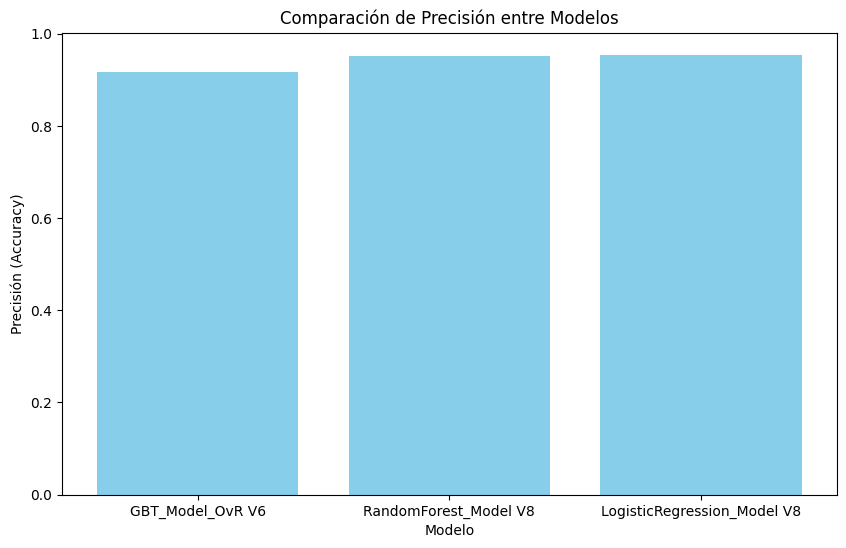

In [26]:
# Datos de precisión de los modelos
metrics_data = {
    "Modelo": ["GBT_Model_OvR V6", "RandomForest_Model V8", "LogisticRegression_Model V8"],
    "Precisión (Accuracy)": [0.9166666666666666, 0.9523809523809523, 0.9545454545454546]
}

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(metrics_data["Modelo"], metrics_data["Precisión (Accuracy)"], color='skyblue')

# Etiquetas y título
plt.title("Comparación de Precisión entre Modelos")
plt.ylabel("Precisión (Accuracy)")
plt.xlabel("Modelo")

# Mostrar el gráfico
plt.show()

## Seleccion de Modelo Ganador

In [28]:
# Definir los modelos y versiones que quieres comparar
models = [
    {"model_name": "GBT_Model_OvR", "version": 6},
    {"model_name": "RandomForest_Model", "version": 8},
    {"model_name": "LogisticRegression_Model", "version": 8}
]

                        Modelo  Validación (Accuracy)  Prueba (Accuracy)  \
0             GBT_Model_OvR V6               0.857143           0.916667   
1        RandomForest_Model V8               0.944444           0.954545   
2  LogisticRegression_Model V8               0.944444           0.954545   

  Weighted Precision Weighted Recall Weighted F1  
0           0.933333        0.916667    0.912963  
1                N/A             N/A         N/A  
2                N/A             N/A         N/A  


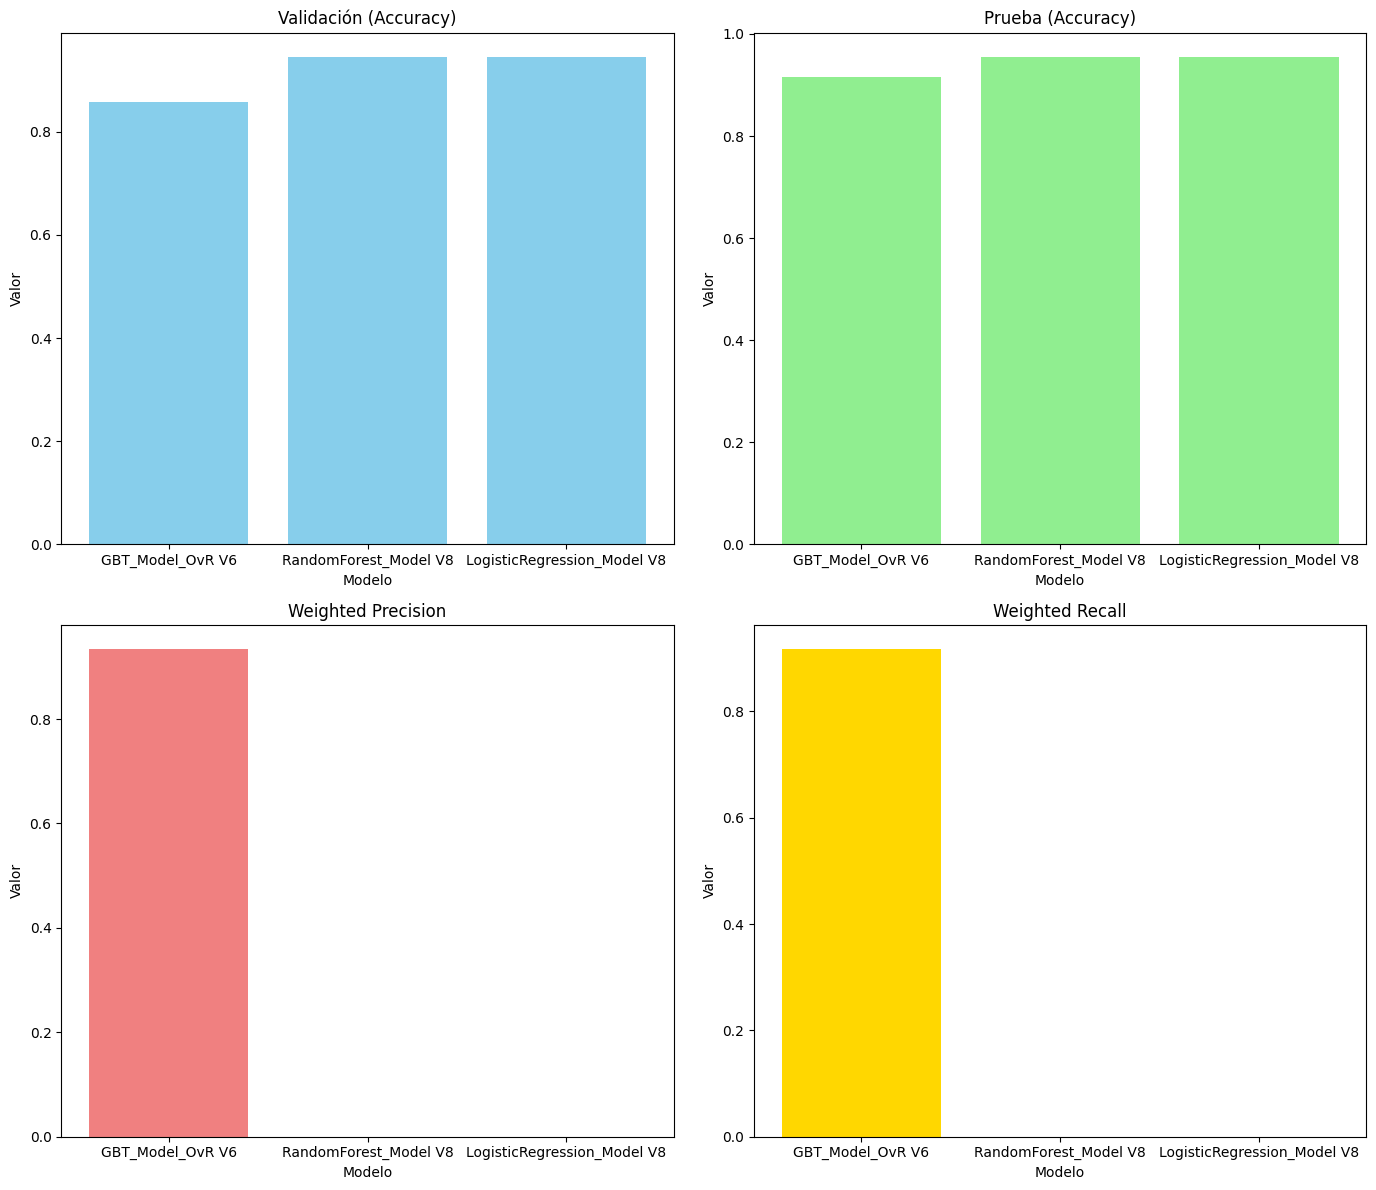

El modelo ganador basado en la métrica de prueba (accuracy) es: RandomForest_Model V8 con un Accuracy de 0.95


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from mlflow.tracking import MlflowClient

# Conectar con el cliente de MLflow
client = MlflowClient()

# Crear listas para almacenar las métricas
metrics_data = {
    "Modelo": [],
    "Validación (Accuracy)": [],
    "Prueba (Accuracy)": [],
    "Weighted Precision": [],
    "Weighted Recall": [],
    "Weighted F1": []
}

# Recuperar las métricas de cada modelo
for model in models:
    model_name = model["model_name"]
    version = model["version"]
    
    # Obtener el 'run_id' de la versión del modelo
    model_version = client.get_model_version(name=model_name, version=version)
    run_id = model_version.run_id

    # Obtener todas las métricas de la ejecución asociada
    metrics = client.get_run(run_id).data.metrics

    # Extraer las métricas específicas para cada modelo
    val_accuracy = metrics.get(f"{model_name}_val_accuracy", None)
    test_accuracy = metrics.get(f"{model_name}_Wine_Data_test_accuracy", None)
    weighted_precision = metrics.get(f"{model_name}_Wine_Data_weightedPrecision", None)
    weighted_recall = metrics.get(f"{model_name}_Wine_Data_weightedRecall", None)
    weighted_f1 = metrics.get(f"{model_name}_Wine_Data_f1", None)

    # Agregar métricas a la lista
    metrics_data["Modelo"].append(f"{model_name} V{version}")
    metrics_data["Validación (Accuracy)"].append(val_accuracy if val_accuracy is not None else "N/A")
    metrics_data["Prueba (Accuracy)"].append(test_accuracy if test_accuracy is not None else "N/A")
    metrics_data["Weighted Precision"].append(weighted_precision if weighted_precision is not None else "N/A")
    metrics_data["Weighted Recall"].append(weighted_recall if weighted_recall is not None else "N/A")
    metrics_data["Weighted F1"].append(weighted_f1 if weighted_f1 is not None else "N/A")

# Convertir las métricas a un DataFrame de pandas para manejar mejor la visualización
df_metrics = pd.DataFrame(metrics_data)

# Imprimir las métricas para verificar los valores
print(df_metrics)

# Crear gráficos para las métricas principales
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Gráfico de Validación (Accuracy)
axes[0, 0].bar(df_metrics["Modelo"], df_metrics["Validación (Accuracy)"].apply(lambda x: float(x) if x != "N/A" else 0), color='skyblue')
axes[0, 0].set_title("Validación (Accuracy)")
axes[0, 0].set_ylabel("Valor")
axes[0, 0].set_xlabel("Modelo")

# Gráfico de Prueba (Accuracy)
axes[0, 1].bar(df_metrics["Modelo"], df_metrics["Prueba (Accuracy)"].apply(lambda x: float(x) if x != "N/A" else 0), color='lightgreen')
axes[0, 1].set_title("Prueba (Accuracy)")
axes[0, 1].set_ylabel("Valor")
axes[0, 1].set_xlabel("Modelo")

# Gráfico de Weighted Precision
axes[1, 0].bar(df_metrics["Modelo"], df_metrics["Weighted Precision"].apply(lambda x: float(x) if x != "N/A" else 0), color='lightcoral')
axes[1, 0].set_title("Weighted Precision")
axes[1, 0].set_ylabel("Valor")
axes[1, 0].set_xlabel("Modelo")

# Gráfico de Weighted Recall
axes[1, 1].bar(df_metrics["Modelo"], df_metrics["Weighted Recall"].apply(lambda x: float(x) if x != "N/A" else 0), color='gold')
axes[1, 1].set_title("Weighted Recall")
axes[1, 1].set_ylabel("Valor")
axes[1, 1].set_xlabel("Modelo")

plt.tight_layout()
plt.show()

# Determinar el modelo ganador basado en la métrica de Prueba (Accuracy)
df_metrics["Prueba (Accuracy)"] = pd.to_numeric(df_metrics["Prueba (Accuracy)"], errors='coerce')
best_model_test = df_metrics.loc[df_metrics["Prueba (Accuracy)"].idxmax()]

# Mostrar el modelo ganador
print(f"El modelo ganador basado en la métrica de prueba (accuracy) es: {best_model_test['Modelo']} "
      f"con un Accuracy de {best_model_test['Prueba (Accuracy)']:.2f}")


                        Modelo  Validación (Accuracy)  Prueba (Accuracy)  \
0             GBT_Model_OvR V6               0.857143           0.916667   
1        RandomForest_Model V8               0.944444           0.954545   
2  LogisticRegression_Model V8               0.944444           0.954545   

   Clase 1 Precision  Clase 1 Recall  Clase 1 F1  Clase 2 Precision  \
0                0.8             1.0    0.888889                1.0   
1                1.0             1.0    1.000000                1.0   
2                1.0             1.0    1.000000                1.0   

   Clase 2 Recall  Clase 2 F1  Clase 3 Precision  Clase 3 Recall  Clase 3 F1  \
0        0.666667    0.800000           1.000000             1.0    1.000000   
1        0.875000    0.933333           0.833333             1.0    0.909091   
2        0.875000    0.933333           0.833333             1.0    0.909091   

   Precision Promedio  Recall Promedio  F1 Promedio  Promedio General  
0            0.93

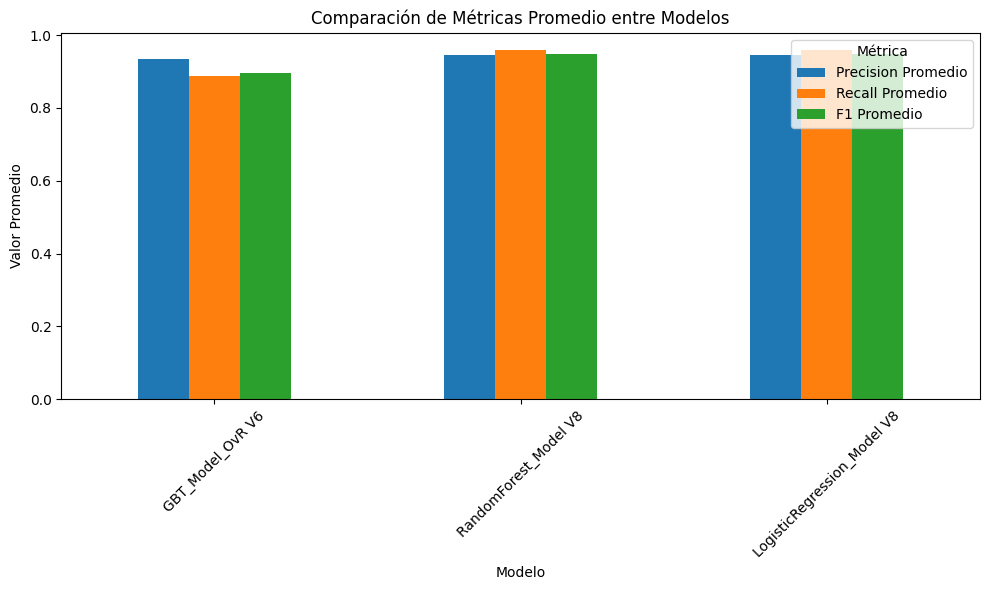

In [30]:
import pandas as pd
from mlflow.tracking import MlflowClient

# Conectar con el cliente de MLflow
client = MlflowClient()

# Definir los modelos y versiones que quieres comparar
models = [
    {"model_name": "GBT_Model_OvR", "version": 6},
    {"model_name": "RandomForest_Model", "version": 8},
    {"model_name": "LogisticRegression_Model", "version": 8}
]

# Crear una lista para almacenar las métricas de cada modelo
metrics_data = []

# Recuperar las métricas de cada modelo y convertirlas a pandas
for model in models:
    model_name = model["model_name"]
    version = model["version"]
    
    # Obtener el 'run_id' de la versión del modelo
    model_version = client.get_model_version(name=model_name, version=version)
    run_id = model_version.run_id

    # Obtener todas las métricas de la ejecución asociada
    metrics = client.get_run(run_id).data.metrics

    # Crear un diccionario para almacenar las métricas de este modelo
    model_metrics = {
        "Modelo": f"{model_name} V{version}",
        "Validación (Accuracy)": metrics.get(f"{model_name}_val_accuracy", None),
        "Prueba (Accuracy)": metrics.get(f"{model_name}_Wine_Data_test_accuracy", None),
    }
    
    # Agregar métricas por clase
    for class_label in range(1, 4):  # Suponiendo 3 clases
        model_metrics[f"Clase {class_label} Precision"] = metrics.get(f"{model_name}_class_{class_label}_precision", None)
        model_metrics[f"Clase {class_label} Recall"] = metrics.get(f"{model_name}_class_{class_label}_recall", None)
        model_metrics[f"Clase {class_label} F1"] = metrics.get(f"{model_name}_class_{class_label}_f1", None)

    # Agregar al conjunto de métricas
    metrics_data.append(model_metrics)

# Convertir todas las métricas a un DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Calcular promedios para Precision, Recall y F1 directamente en pandas
for metric in ["Precision", "Recall", "F1"]:
    class_columns = [col for col in df_metrics.columns if metric in col]
    df_metrics[f"{metric} Promedio"] = df_metrics[class_columns].mean(axis=1, skipna=True)

# Calcular el Promedio General
df_metrics["Promedio General"] = df_metrics[["Precision Promedio", "Recall Promedio", "F1 Promedio"]].mean(axis=1, skipna=True)

# Imprimir las métricas en formato tabular
print(df_metrics)

# Determinar el modelo ganador basado en el Promedio General
best_model = df_metrics.loc[df_metrics["Promedio General"].idxmax()]

# Mostrar el modelo ganador
print(f"El modelo ganador basado en el promedio general es: {best_model['Modelo']} "
      f"con un Promedio General de {best_model['Promedio General']:.2f}")

# Crear un gráfico de barras para comparar las métricas promedio
metrics_to_plot = ["Precision Promedio", "Recall Promedio", "F1 Promedio"]
df_metrics_plot = df_metrics[["Modelo"] + metrics_to_plot]

# Crear el gráfico
df_metrics_plot.set_index("Modelo")[metrics_to_plot].plot(kind="bar", figsize=(10, 6))

# Configurar títulos y etiquetas
plt.title("Comparación de Métricas Promedio entre Modelos")
plt.ylabel("Valor Promedio")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.legend(title="Métrica")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [31]:
print('Finalizacion')

Finalizacion
